##**Pips**

In [ ]:
!pip install yfinance
!pip install --upgrade yfinance
!pip show yfinance
!pip install emcee # astronomy mcmc runner, sorry!
!pip install emcee --upgrade
!pip install corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.59
    Uninstalling yfinance-0.2.59:
      Successfully uninstalled yfinance-0.2.59
Name: yfinance
Version: 0.2.61
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /usr/local/lib/python3.11/dist-packages
Requires: beautifulsoup4, curl_cffi, frozendict, multitasking, numpy, pandas, peewee, platformdirs, protobuf, pytz, requests, websockets
Required-by: 
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.8 MB/s eta 0:00:00


##**Data**

In [ ]:
# Import necessary packages
import yfinance as yf
import pandas as pd
import random
import numpy as np
import time
import random
from numpy.linalg import norm
import seaborn as sb
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.cm as cm
import requests
import emcee
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Get the list of S&P 500 tickers from Wikipedia, the most effective for what we are doing
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(sp500_url, header=0)[0]

# Extract tickers from the 'Symbol' column
sp500_tickers = sp500_table['Symbol'].tolist()

In [ ]:
# Sets tickers to a with an adjustable number of them selected
n = 11
assets = np.random.choice(sp500_tickers, n) # actaully gets them
print(assets)

['OKE' 'WDAY' 'GS' 'APD' 'CL' 'D' 'VTR' 'DIS' 'ARE' 'PEP' 'MTCH']


In [ ]:
# returns all of the needed ticker data for our analyses
def expected_return(tickers):
    expected_returns_avg = pd.DataFrame() # empty df
    returns_quarterly = pd.DataFrame() # empty df
    dropped_tickers = [] # empty list

    # Define time range: from 2020 Q1 to just before 2024
    start_date = pd.to_datetime("2020-01-01").tz_localize("America/New_York") # want to start it in 2020 (start of covid)
    cutoff_date = pd.to_datetime("2024-01-01").tz_localize("America/New_York") # end the firts day fo 2024, so we can predict the end of 2025 evaluation

    for ticker in tickers: # these are determined in the cell above
        try:
            # calls and gets the ticker data using yfinance
            obj = yf.Ticker(ticker)
            symbol = obj.info.get('symbol',ticker)
            hist = obj.history(period="10y",auto_adjust=True,interval="3mo") # set to take quarterly data for a longer period than we will need, later is cut down

            if hist.empty or 'Close' not in hist.columns: # notes the tickers which could not have their data fetched
                dropped_tickers.append(ticker)
                continue

            # tehcnical code bc the timezome was causing errors, this is important when we drop data based on dates
            if hist.index.tz is None:
                hist = hist.tz_localize("America/New_York")
            else:
                hist = hist.tz_convert("America/New_York")

            # Filter to be all quarterly 2020-2023 data, note these are based off variables we made earlier in the code
            hist = hist[(hist.index>=start_date)&(hist.index<cutoff_date)]

            if hist.empty: # again to note tickers which were dropped bc of the new date constraints
                dropped_tickers.append(ticker)
                continue

            # calculate returns
            return_quarterly = hist['Close'].pct_change() # takes the close on the day
            returns_quarterly[symbol] = return_quarterly # sets it to the specific ticker

        except Exception as e: # to visualize the dropped tickers in our process, and for when others use the notebook it will be apparent their random generation was not perfectly usable
            print(f"Skipping {ticker} due to error: {e}")
            dropped_tickers.append(ticker)
            continue

    # Handle missing data
    returns_quarterly = returns_quarterly.ffill().bfill()  # fixes deprecated fillna
    all_nan_cols = returns_quarterly.columns[returns_quarterly.isna().all()] # if any have completely missing columns, drop
    dropped_tickers.extend(all_nan_cols.tolist()) # add tickers that were dropped to report them, again
    returns_quarterly.dropna(axis=1,how='all',inplace=True) # drop any that still are all na just incase

    # Calculate expected returns
    expected_returns_avg[0] = returns_quarterly.mean(axis=0) # the mean of all of the quarterly returns
    print(f"Dropped tickers: {dropped_tickers}") # view the dropped tickers
    return expected_returns_avg, returns_quarterly # returns the final needed data points for our optimization


# just prints an example, never used again really, just to test the waters and see what the data is looking like
expected_returns_avg, returns_quarterly = expected_return(assets)
returns = expected_returns_avg.values.flatten()
print(expected_returns_avg)

Dropped tickers: []
             0
OKE   0.077611
WDAY  0.065216
GS    0.069575
APD   0.037144
CL    0.025109
D    -0.014451
VTR   0.057068
DIS   0.006607
ARE   0.009697
PEP   0.026575
MTCH  0.006247


##**Model**

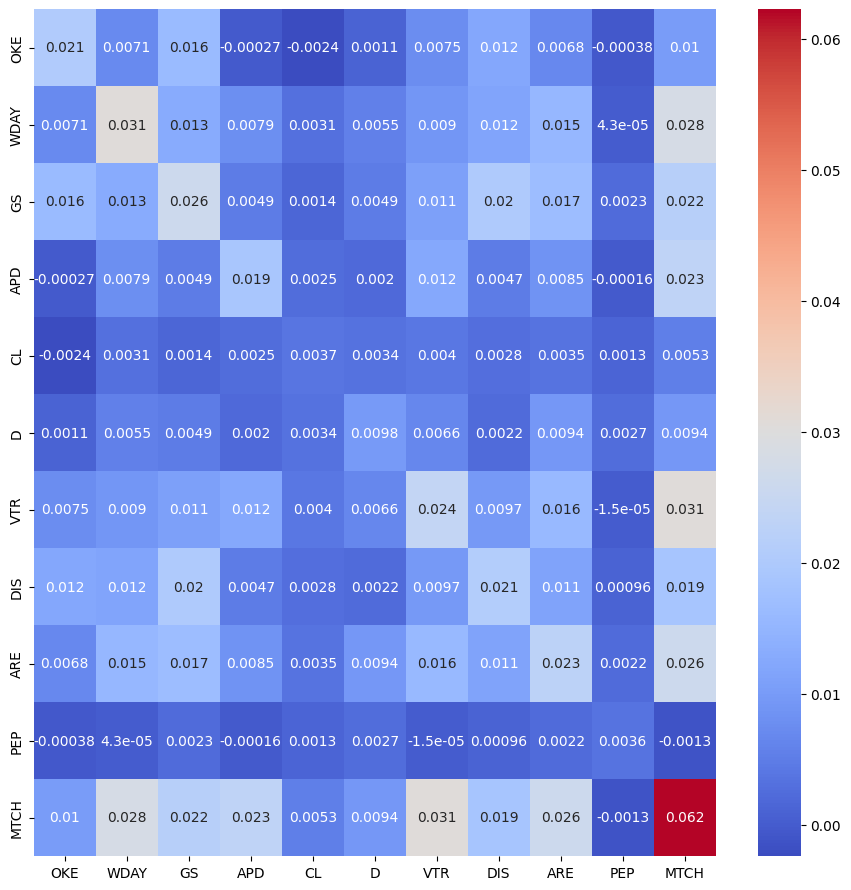

initial-weights: [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
portfolio_variance: 0.009496700913703778
portfolio_return: 0    0.033309
dtype: float64


In [ ]:
# Intialize the weights
n_assets = len(expected_returns_avg)
weight = np.ones(n_assets,dtype=float) # Initialize with dtype=float, and use the correct name for weights here
weight /= weight.sum()

# defining the portfolio_return function
def portfolio_return(weights, returns):
    portfolio_return = weights@returns  # how its actually calculated
    return portfolio_return

# covariance matrix for the quarterly data
returns_cov = returns_quarterly.cov()  # covariance matrix fo the quarterly data

# to plot and visualize this initial covariance matrix that we base so much on
fig, ax = plt.subplots(figsize=(n_assets, n_assets))
sb.heatmap(returns_cov,annot=True,cmap='coolwarm')  # formatting and consistent color scheme
plt.show()

# defining the portfolio_variance, and adding the cov_matrix as an argument
def portfolio_variance(weights,cov_matrix):
    return weights.T@cov_matrix@weights  # just the math behind it using matrix multiplication

# for visualization of the data we will be using in the optimizer, and again in final comparison after MCMC
print("initial-weights:", weight) # Make sure the weight is in the correct format or shape for cov_matrix
print("portfolio_variance:", portfolio_variance(weight,returns_cov))
print("portfolio_return:", portfolio_return(weight,expected_returns_avg)) # make sure weight is either converted or returns is changed to returns

In [ ]:
# the objective function
def sharpe_objective(weights,mu,cov):
    portfolio_return = weights@mu # the portfolio return in terms of the stock weights and the mean returns
    portfolio_volatility = np.sqrt(weights@cov@ weights.T) # the variability in terms of the weights and covariance matrix of the quarterly returns
    return -(portfolio_return / portfolio_volatility)  # negative sharpe ratio for minimization by gradient descent

# gradient of the objective function
def sharpe_gradient(weights, mu, cov):
    port_return = weights@mu # repeating what's above so that can reference inside the function
    port_volatility = np.sqrt(weights@ cov@ weights.T) # same as above
    # below is the actual gradient computation
    numerator = mu*port_volatility-(port_return/port_volatility) *cov@weights # numerator of the gradient
    denominator = port_volatility**2 # denominator of the gradient
    return -(numerator / denominator)  # negative gradient for minimization

# the optimizer
def gradient_descent(mu, cov, initial_weights, step_size=0.01, threshold=1e-5, max_iterations=10000):

    # diagonal scaling technique, adapted bc the normal one did not always work
    std_devs = np.sqrt(np.diag(cov)) # get standard deviations of each asset
    D = np.diag(1.0 / std_devs) # create inverse volatility scaling matrix
    mu_scaled = D @ mu # scale expected returns
    cov_scaled = D @ cov @ D # scale covariance matrix

    # scaled intial weights
    x_initial = D @ initial_weights # bang, done right here
    x_initial /= x_initial.sum() # normalized scaled weights

    x = x_initial.copy().astype(float) # calling these initial weights from the previous cell
    iteration = 0 # the first iteration is zero
    # bunch of empty lists to store values in for visualization and analysis
    objective_values = []
    weights_history = []
    portfolio_variances = []
    portfolio_returns = []

    while iteration < max_iterations: # stopping criterion (outer loop)
        grad = sharpe_gradient(x, mu_scaled, cov_scaled) # grad
        grad_norm = np.linalg.norm(grad) # norm

        if grad_norm < threshold: # stopping criterion which is actually used, almost always will be this one
            print(f"Converged after {iteration} iterations.")
            break # actually stops the optimization once it does

        # gradient descent
        direction = -grad  # normal gradient descent syntax and theory
        x = x + step_size * direction # updates the scaled weights
        x /= x.sum() # renormalize

        # transform BACK to original weight space so the values are correct
        weights = D @ x
        weights /= weights.sum() # renormalize in the regular space

        # Record metrics
        current_objective = sharpe_objective(weights,mu,cov) # the values of the objective as iterations go by
        objective_values.append(current_objective)
        weights_history.append(weights.copy()) # the weights as time goes by

        # calculates portfolio return and variance
        portfolio_return = weights@mu # same as at the beginning but updated values
        portfolio_variance = weights@cov@weights.T # here too

        portfolio_returns.append(portfolio_return) # adds the new values
        portfolio_variances.append(portfolio_variance) # same as above
        iteration += 1

    if iteration == max_iterations: # if it hits the max iteration have this, to keep runtime down
        print("Reached maximum number of iterations.")

    return weights, iteration, objective_values, weights_history, portfolio_variances, portfolio_returns # returns all of the optimized values sometimes this will return weights which are just straight lines

In [ ]:
# bc we are doing this for any portfolio, these need to be played with for each one, but realtively similar: they are all their own problem with different
# had to use const step size, bc exact line search and backtracking did not work for all portfolios bc of bad gradient functions but constant step did which we determined after extensive testing
# runs the optimizer
optimized_weights, iterations, objective_values, weights_history, portfolio_variances, portfolio_returns = gradient_descent(
    mu=returns,
    cov=returns_cov,
    initial_weights=weight,
    step_size=0.01, # lower this if oscillates and it will converge, this may also need to be increased depending on the portfolio some are extremely ill conditioned, this is just what happened to work for the last one ran
    threshold=1e-4,
    max_iterations=10000 # also may have to increase this is the convergence looks almost done but is not
)

# calculates the sharpe ratios for before and after the optimizer
initial_sharpe = portfolio_return(weight, returns)/np.sqrt(portfolio_variance(weight, returns_cov))
optimized_sharpe = portfolio_return(optimized_weights, returns)/np.sqrt(portfolio_variance(optimized_weights, returns_cov))

# builds output table
data = [
    ["initial_weights", weight.tolist()],
    ["initial_portfolio_return", portfolio_return(weight, returns)],
    ["initial_portfolio_variance", portfolio_variance(weight, returns_cov)],
    ["initial_portfolio_sharpe", initial_sharpe],
    ["optimized_weights", optimized_weights.tolist()],
    ["optimized_portfolio_return", portfolio_return(optimized_weights, returns)],
    ["optimized_portfolio_variance", portfolio_variance(optimized_weights, returns_cov)],
    ["optimized_portfolio_sharpe", optimized_sharpe],
    ["optimized_objective_value", sharpe_objective(optimized_weights, returns, returns_cov)], # Assuming sharpe_objective is the intended objective function
    ["number_of_iterations", iterations],
    ["initial_sharpe", initial_sharpe],
    ["optimized_sharpe", optimized_sharpe]
]

# Create and display DataFrame
df = pd.DataFrame(data, columns=["parameters", "Values"])
print(tabulate(df, headers="keys", tablefmt="psql"))

Reached maximum number of iterations.
+----+------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | parameters                   | Values                                                                                                                                                                                                                                  |
|----+------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | initial_weights              | [0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.

Dropped tickers: []


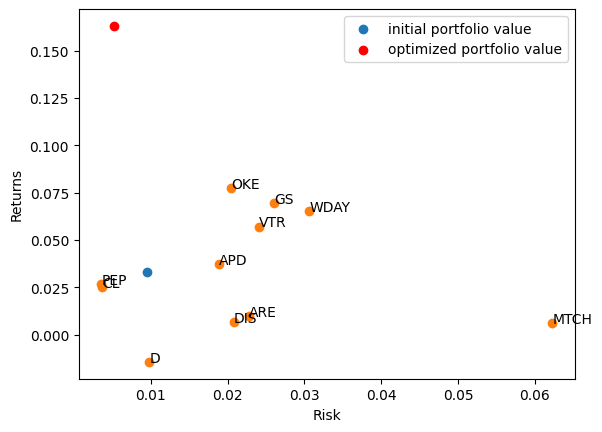

In [ ]:
#plot the graphs returns vs risk

expected_returns, values = expected_return(assets)  # returns from live market of the stocks
variances = np.diagonal(returns_cov)  # variance of each data assets

valid_assets = expected_returns.index.tolist()

for i, asset in enumerate(valid_assets):
    plt.annotate(asset, (variances[i], expected_returns.loc[asset].values[0]))  # text

plt.scatter(portfolio_variance(weight,returns_cov),portfolio_return(weight,returns),label="initial portfolio value")
plt.scatter(portfolio_variance(optimized_weights,returns_cov), portfolio_return(optimized_weights,returns), color="red", label="optimized portfolio value")
plt.scatter(variances,returns)
plt.xlabel("Risk")
plt.ylabel("Returns")
plt.legend()
plt.show()

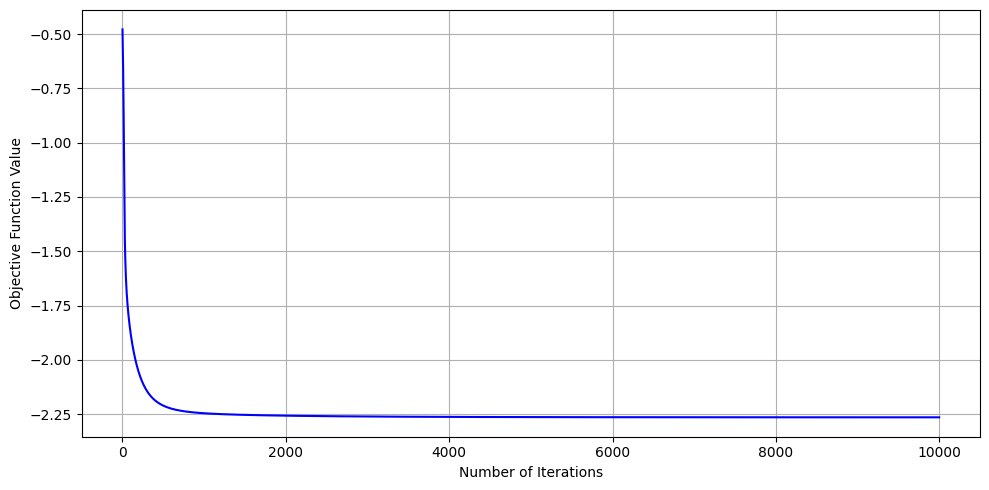

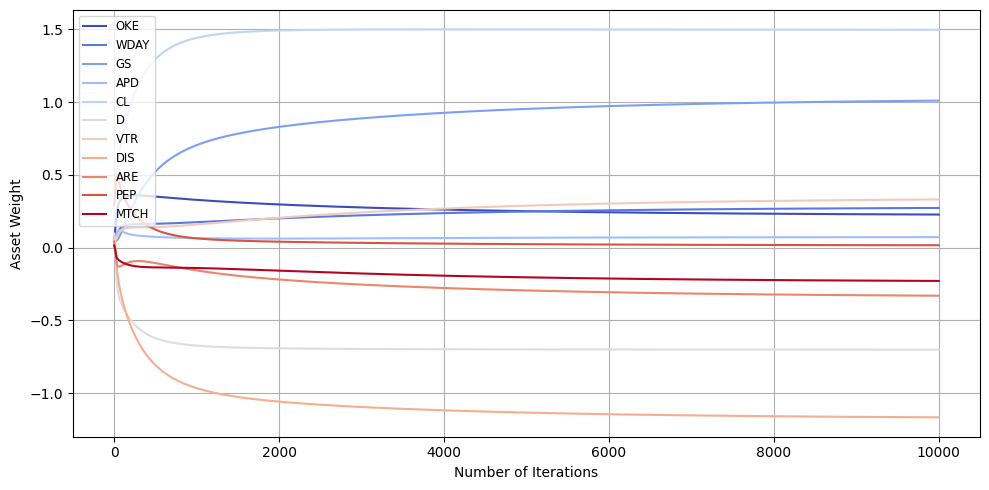

''

In [ ]:
# objective function vs iterations
plt.figure(figsize=(10, 5))
plt.plot(range(len(objective_values)),objective_values,linestyle='-', color='blue')
plt.xlabel("Number of Iterations")
plt.ylabel("Objective Function Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# weigts vs iterations
# makes the weights an array for plotting purposes
weights_array = np.array(weights_history)
cmap = cm.get_cmap('coolwarm',weights_array.shape[1])  # number of assets, also a consistent coloring
# the actual plotting code
plt.figure(figsize=(10, 5))
for i in range(weights_array.shape[1]):
    plt.plot(weights_array[:, i],label=assets[i],color=cmap(i))

plt.xlabel("Number of Iterations")
plt.ylabel("Asset Weight")
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

##**MCMC Forecasting**

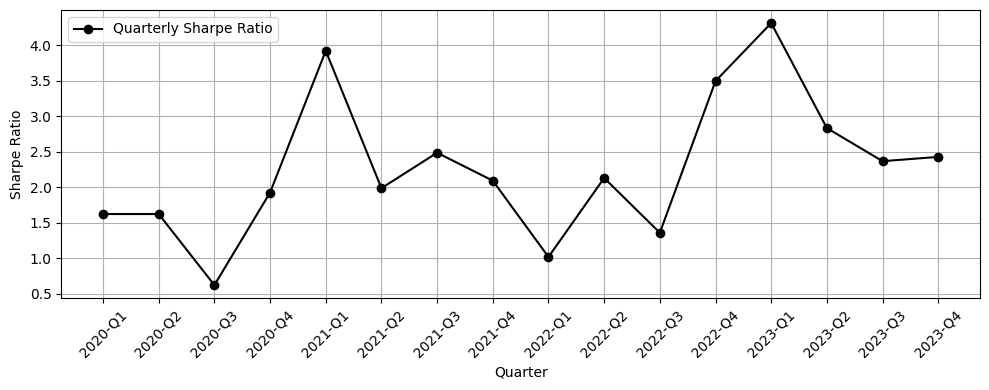

In [ ]:
weights = optimized_weights.copy() # use the optimized weigths

# gets the recent returns
recent_returns = returns_quarterly.iloc[-40:] # gets more data than I even have out of laziness, they wont get plotted regardless
n_quarters,n_assets = recent_returns.shape # gets the shape

# computes the covariance matrix from historical data (again), just recalling the variable I used earlier in the code
returns_cov = recent_returns.cov().values

# portfolio volatility same as what was done before
port_volatility = np.sqrt(weights@returns_cov@weights.T)

# empty list for the empty list
sharpe_history = []

for t in range(n_quarters): # the number of quarters that I actually have data for, but on a roling window
    quarter_return = recent_returns.iloc[t].values # gets the data
    port_return = weights@quarter_return # same as in the optimizer
    ratio = port_return/port_volatility  # here as well
    sharpe_history.append(ratio) # appends the empty list so can use the values later one

# convert it to numpy array so I can plot it and analyze it in mcmc
sharpe_history = np.array(sharpe_history)

# plots it, lot of little fromatting things in there as well
plt.figure(figsize=(10, 4))
plt.plot(sharpe_history, 'ko-', label='Quarterly Sharpe Ratio')
plt.xlabel('Quarter')
plt.ylabel('Sharpe Ratio')
# fomratting of the tick marks ot make it look nicer and actually be seen
plt.xticks(
    np.arange(len(recent_returns)),
    [f"{d.year}-Q{((d.month - 1)// 3) + 1}" for d in recent_returns.index],
    rotation=45
)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:26<00:00, 380.75it/s]


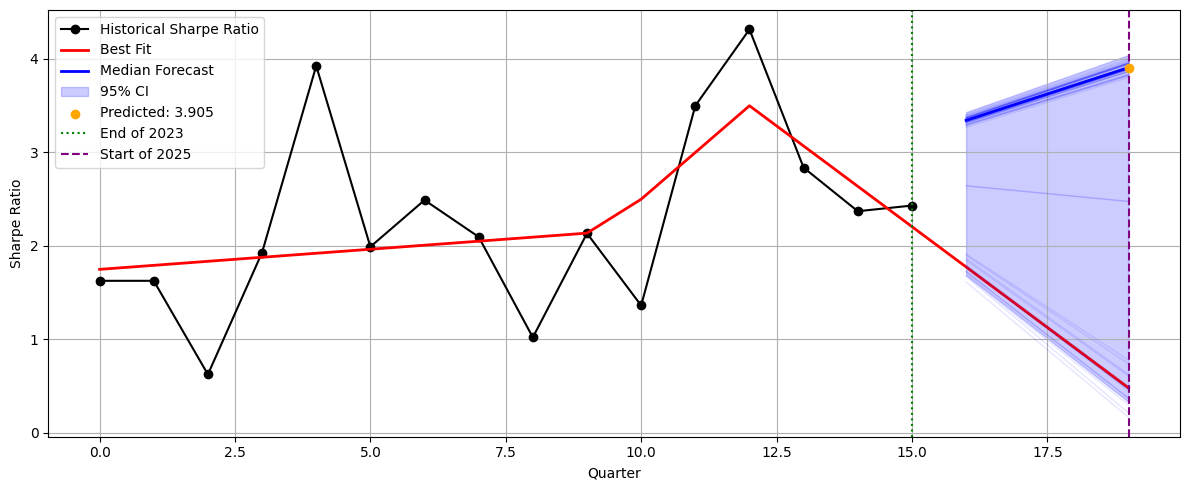

Predicted Sharpe Ratio at Q19: 3.905
95% Confidence Interval: [0.328, 4.039]


In [ ]:
random.seed(11)
# Define data
x = np.arange(len(sharpe_history)) # gets the number of quarter
y = sharpe_history # the actual ratios
N = len(x)

# continuous piecewise linear model with 3 segments and adaptive slopes and changepoints, no data input
def piecewise(x, cp1, cp2, m1, b1, m2, m3): # the initial parameters
    b2 = (m1 - m2) *cp1 +b1 # the intercept so that it conencts, second line
    b3 = (m2 - m3) *cp2 +b2 # here but for the third line
    y_model = np.zeros_like(x, dtype=float) # empty to add values into later
    for i, xi in enumerate(x): # loop over the x values to find the y values
        if xi < cp1:
            y_model[i] = m1*xi+b1 # before change 1
        elif xi < cp2:
            y_model[i] = m2*xi+b2 # before change 2
        else:
            y_model[i] = m3*xi+b3 # final line
    return y_model

# log-likelihood with added uncertainty so that it fits the data more loosely, bc if not just matches very short periods not general trends
def log_likelihood(theta, x, y):
    cp1, cp2, m1, b1, m2, m3 = theta # unpacks the input
    cp1 = np.clip(cp1, 1.0, N - 3 - 1e-6) # clips unrealistic change points
    cp2 = np.clip(cp2, cp1 + 1e-6, N - 2 - 1e-6) # clips unrealistic change points
    model = piecewise(x, cp1, cp2,m1, b1, m2, m3) # references the function defined above to actually get the lines
    sigma = 0.05 # noise is added with this, made a variable so can play around with it to find the best fits
    return -0.5 * np.sum(((y - model)/sigma)**2 + np.log(2 *np.pi* sigma ** 2)) # gaussian normal noise assumption, but taking the log

# tightened log-prior to avoid multimodal behavior
def log_prior(theta):
    cp1, cp2, m1, b1, m2, m3 = theta # againunpack the
    # Changepoint constraints (stronger middle restriction)
    if not (0.2 * N <= cp1 <cp2 <= 0.8 * N):  # Narrower bounds
        return -np.inf
    # slope constraints, relatively tight to encourage shallower slopes
    if not (-.5 < m1 < .5 and -.5 < m2 < .5 and -.5 < m3 < .5):
        return -np.inf
    # intercept constraints, again little closer ot reduce extremity
    if not (-5 < b1 < 5):
        return -np.inf
    return 0.0

# Posterior function, using the fucntions above
def log_posterior(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(theta, x, y) # log base so can add them like this, common emcee practice to frmulate like this for stability

# initialization
init_guess = [N/3, 2*N/3, 0.05, y[0], 0.05, 0.05]  # eh guess
pos = init_guess + 1e-4 * np.random.randn(36, 6)  # eh guess

# run MCMC, big burnin incase (sorry I use the astronomy mcmc package)
sampler = emcee.EnsembleSampler(36, 6, log_posterior, args=(x, y))
sampler.run_mcmc(pos, 10000, progress=True)

# extract best fit
flat_samples = sampler.get_chain(discard=5000, thin=10, flat=True)
best_idx = np.argmax([log_posterior(p, x, y) for p in flat_samples]) # the data
best_fit = flat_samples[best_idx] # flattens it for easy access
cp1, cp2, m1, b1, m2, m3 = best_fit # the values
cp1 = np.clip(cp1, 1.0, N - 3 - 1e-6) # ensures not too close to the beginning or the end to not just follow the extremely localized trend
cp2 = np.clip(cp2, cp1 + 1e-6, N - 2 - 1e-6) # here as well bbut the second changepoint

# forecast settings
QUARTERS_AHEAD = 4 # we played aroung with this, but one year made the most logical sense, hence 4 quarters
x_forecast = np.arange(N, N + QUARTERS_AHEAD)  # just simply doing the initialization with
num_samples = flat_samples.shape[0] # gets the samples and indexing needed terms
predictions = np.zeros((num_samples, QUARTERS_AHEAD)) # empty array of the correct

# generate predictions for all posterior samples
for i, theta in enumerate(flat_samples):
    cp1_s, cp2_s, m1_s, b1_s, m2_s, m3_s = theta # unpacks the variables
    cp1_s = np.clip(cp1_s, 1.0, N - 3 - 1e-6) # same clipping
    cp2_s = np.clip(cp2_s, cp1_s + 1e-6, N - 2 - 1e-6) # here aswell
    y_pred = piecewise(x_forecast, cp1_s, cp2_s, m1_s, b1_s, m2_s, m3_s) # calls the fucntion fro it again
    predictions[i] = y_pred # gets the predictions

# compute CI from the bayesian inference
ci_lower = np.percentile(predictions,2.5,axis=0)
ci_upper = np.percentile(predictions,97.5,axis=0)
median_forecast = np.median(predictions,axis=0) # this is what is used as the predicted val.

# evaluate best-fit model up to 2025
x_full = np.arange(N+4)  # through 2025
best_fit_model = piecewise(x_full, cp1, cp2, m1, b1, m2, m3) # again putting into the function

# plot prediction with CI and mcmc chains to see it better
plt.figure(figsize=(12, 5))
plt.plot(x, y, 'ko-', label='Historical Sharpe Ratio')
plt.plot(x_full, best_fit_model, 'r-', lw=2, label='Best Fit') # for the fitted data

# plot posterior samples of the predictions, like the CI (kinda)
for i, theta in enumerate(flat_samples[:50]):
    cp1_s, cp2_s, m1_s, b1_s, m2_s, m3_s = theta
    cp1_s = np.clip(cp1_s, 1.0, N - 3 - 1e-6) # the same clipping as always
    cp2_s = np.clip(cp2_s, cp1_s + 1e-6, N - 2 - 1e-6)
    y_pred = piecewise(x_forecast, cp1_s, cp2_s, m1_s, b1_s, m2_s, m3_s) # calls the function once more
    plt.plot(x_forecast, y_pred, 'b-', alpha=0.1, lw=1) # plots

# plot median forecast and CI
plt.plot(x_forecast, median_forecast, 'b',lw=2, label='Median Forecast') # our predicted value
plt.fill_between(x_forecast, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI') # the corresponding CI

# highlight current and predicted point, so know where it is visually
plt.scatter([x_forecast[-1]], [median_forecast[-1]], color='orange', zorder=5,
            label=f'Predicted: {median_forecast[-1]:.3f}')

# vertical lines, pretty simple code but just makes a vertical line for the end of fitting then predicted model endpoint
plt.axvline(N - 1, color='green',linestyle=':', label='End of 2023')
plt.axvline(x_forecast[-1], color='purple',linestyle='--', label='Start of 2025')
plt.xlabel('Quarter')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# to observe the exact values for writing the report, all fust referencing the correct stuff above
print(f"Predicted Sharpe Ratio at Q19: {median_forecast[-1]:.3f}")
print(f"95% Confidence Interval: [{ci_lower[-1]:.3f}, {ci_upper[-1]:.3f}]")

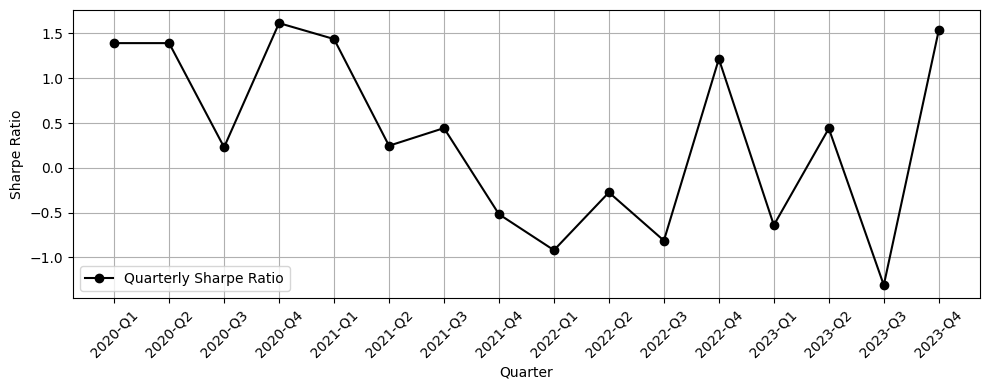

In [ ]:
weights = weight.copy() # use the optimized weigths

# gets the recent returns
recent_returns = returns_quarterly.iloc[-40:] # gets more data than I even have out of laziness, they wont get plotted regardless
n_quarters,n_assets = recent_returns.shape # gets the shape

# computes the covariance matrix from historical data (again), just recalling the variable I used earlier in the code
returns_cov = recent_returns.cov().values

# portfolio volatility same as what was done before
port_volatility = np.sqrt(weights@returns_cov@weights.T)

# empty list for the empty list
sharpe_historyi = []

for t in range(n_quarters): # the number of quarters that I actually have data for, but on a roling window
    quarter_return = recent_returns.iloc[t].values # gets the data
    port_return = weights@quarter_return # same as in the optimizer
    ratio = port_return/port_volatility  # here as well
    sharpe_historyi.append(ratio) # appends the empty list so can use the values later one

# convert it to numpy array so I can plot it and analyze it in mcmc
sharpe_historyi = np.array(sharpe_historyi)

# plots it, lot of little fromatting things in there as well
plt.figure(figsize=(10, 4))
plt.plot(sharpe_historyi, 'ko-', label='Quarterly Sharpe Ratio')
plt.xlabel('Quarter')
plt.ylabel('Sharpe Ratio')
# fomratting of the tick marks ot make it look nicer and actually be seen
plt.xticks(
    np.arange(len(recent_returns)),
    [f"{d.year}-Q{((d.month - 1)// 3) + 1}" for d in recent_returns.index],
    rotation=45
)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:25<00:00, 389.04it/s]


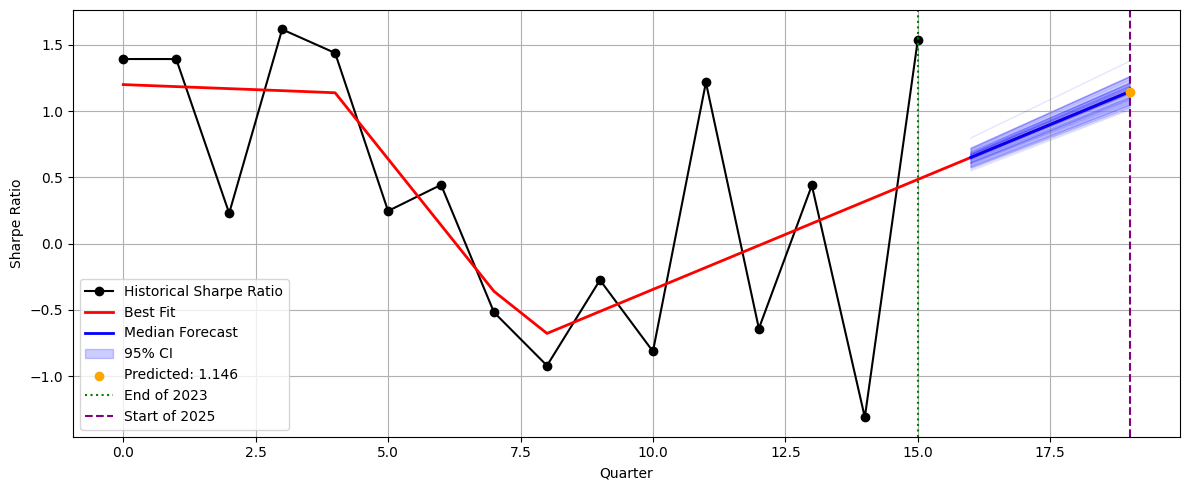

Predicted Sharpe Ratio at Q19: 1.146
95% Confidence Interval: [1.029, 1.262]


In [ ]:
random.seed(11)
# Define data
x = np.arange(len(sharpe_historyi)) # gets the number of quarter
y = sharpe_historyi # the actual ratios
N = len(x)

# continuous piecewise linear model with 3 segments and adaptive slopes and changepoints, no data input
def piecewise(x, cp1, cp2, m1, b1, m2, m3): # the initial parameters
    b2 = (m1 - m2) *cp1 +b1 # the intercept so that it conencts, second line
    b3 = (m2 - m3) *cp2 +b2 # here but for the third line
    y_model = np.zeros_like(x, dtype=float) # empty to add values into later
    for i, xi in enumerate(x): # loop over the x values to find the y values
        if xi < cp1:
            y_model[i] = m1*xi+b1 # before change 1
        elif xi < cp2:
            y_model[i] = m2*xi+b2 # before change 2
        else:
            y_model[i] = m3*xi+b3 # final line
    return y_model

# log-likelihood with added uncertainty so that it fits the data more loosely, bc if not just matches very short periods not general trends
def log_likelihood(theta, x, y):
    cp1, cp2, m1, b1, m2, m3 = theta # unpacks the input
    cp1 = np.clip(cp1, 1.0, N - 3 - 1e-6) # clips unrealistic change points
    cp2 = np.clip(cp2, cp1 + 1e-6, N - 2 - 1e-6) # clips unrealistic change points
    model = piecewise(x, cp1, cp2,m1, b1, m2, m3) # references the function defined above to actually get the lines
    sigma = 0.05 # noise is added with this, made a variable so can play around with it to find the best fits
    return -0.5 * np.sum(((y - model)/sigma)**2 + np.log(2 *np.pi* sigma ** 2)) # gaussian normal noise assumption, but taking the log

# tightened log-prior to avoid multimodal behavior
def log_prior(theta):
    cp1, cp2, m1, b1, m2, m3 = theta # againunpack the
    # Changepoint constraints (stronger middle restriction)
    if not (0.2 * N <= cp1 <cp2 <= 0.8 * N):  # Narrower bounds
        return -np.inf
    # slope constraints, relatively tight to encourage shallower slopes
    if not (-.5 < m1 < .5 and -.5 < m2 < .5 and -.5 < m3 < .5):
        return -np.inf
    # intercept constraints, again little closer ot reduce extremity
    if not (-5 < b1 < 5):
        return -np.inf
    return 0.0

# Posterior function, using the fucntions above
def log_posterior(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(theta, x, y) # log base so can add them like this, common emcee practice to frmulate like this for stability

# initialization
init_guess = [N/3, 2*N/3, 0.05, y[0], 0.05, 0.05]  # eh guess
pos = init_guess + 1e-4 * np.random.randn(36, 6)  # eh guess

# run MCMC, big burnin incase (sorry I use the astronomy mcmc package)
sampler = emcee.EnsembleSampler(36, 6, log_posterior, args=(x, y))
sampler.run_mcmc(pos, 10000, progress=True)

# extract best fit
flat_samples = sampler.get_chain(discard=5000, thin=10, flat=True)
best_idx = np.argmax([log_posterior(p, x, y) for p in flat_samples]) # the data
best_fit = flat_samples[best_idx] # flattens it for easy access
cp1, cp2, m1, b1, m2, m3 = best_fit # the values
cp1 = np.clip(cp1, 1.0, N - 3 - 1e-6) # ensures not too close to the beginning or the end to not just follow the extremely localized trend
cp2 = np.clip(cp2, cp1 + 1e-6, N - 2 - 1e-6) # here as well bbut the second changepoint

# forecast settings
QUARTERS_AHEAD = 4 # we played aroung with this, but one year made the most logical sense, hence 4 quarters
x_forecast = np.arange(N, N + QUARTERS_AHEAD)  # just simply doing the initialization with
num_samples = flat_samples.shape[0] # gets the samples and indexing needed terms
predictions = np.zeros((num_samples, QUARTERS_AHEAD)) # empty array of the correct

# generate predictions for all posterior samples
for i, theta in enumerate(flat_samples):
    cp1_s, cp2_s, m1_s, b1_s, m2_s, m3_s = theta # unpacks the variables
    cp1_s = np.clip(cp1_s, 1.0, N - 3 - 1e-6) # same clipping
    cp2_s = np.clip(cp2_s, cp1_s + 1e-6, N - 2 - 1e-6) # here aswell
    y_pred = piecewise(x_forecast, cp1_s, cp2_s, m1_s, b1_s, m2_s, m3_s) # calls the fucntion fro it again
    predictions[i] = y_pred # gets the predictions

# compute CI from the bayesian inference
ci_lower = np.percentile(predictions,2.5,axis=0)
ci_upper = np.percentile(predictions,97.5,axis=0)
median_forecast = np.median(predictions,axis=0) # this is what is used as the predicted val.

# evaluate best-fit model up to 2025
x_full = np.arange(N+4)  # through 2025
best_fit_model = piecewise(x_full, cp1, cp2, m1, b1, m2, m3) # again putting into the function

# plot prediction with CI and mcmc chains to see it better
plt.figure(figsize=(12, 5))
plt.plot(x, y, 'ko-', label='Historical Sharpe Ratio')
plt.plot(x_full, best_fit_model, 'r-', lw=2, label='Best Fit') # for the fitted data

# plot posterior samples of the predictions, like the CI (kinda)
for i, theta in enumerate(flat_samples[:50]):
    cp1_s, cp2_s, m1_s, b1_s, m2_s, m3_s = theta
    cp1_s = np.clip(cp1_s, 1.0, N - 3 - 1e-6) # the same clipping as always
    cp2_s = np.clip(cp2_s, cp1_s + 1e-6, N - 2 - 1e-6)
    y_pred = piecewise(x_forecast, cp1_s, cp2_s, m1_s, b1_s, m2_s, m3_s) # calls the function once more
    plt.plot(x_forecast, y_pred, 'b-', alpha=0.1, lw=1) # plots

# plot median forecast and CI
plt.plot(x_forecast, median_forecast, 'b',lw=2, label='Median Forecast') # our predicted value
plt.fill_between(x_forecast, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI') # the corresponding CI

# highlight current and predicted point, so know where it is visually
plt.scatter([x_forecast[-1]], [median_forecast[-1]], color='orange', zorder=5,
            label=f'Predicted: {median_forecast[-1]:.3f}')

# vertical lines, pretty simple code but just makes a vertical line for the end of fitting then predicted model endpoint
plt.axvline(N - 1, color='green',linestyle=':', label='End of 2023')
plt.axvline(x_forecast[-1], color='purple',linestyle='--', label='Start of 2025')
plt.xlabel('Quarter')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# to observe the exact values for writing the report, all fust referencing the correct stuff above
print(f"Predicted Sharpe Ratio at Q19: {median_forecast[-1]:.3f}")
print(f"95% Confidence Interval: [{ci_lower[-1]:.3f}, {ci_upper[-1]:.3f}]")